Iniciais

In [6]:
import pygame
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from collections import defaultdict

# parametros da simulacao
quantidade_inicial_particulas = 200
min_particulas = 10
max_particulas = 500

raio_particula:  np.float64 = 0.5  # nm
massa_particula: np.float64 = 1 * 1.66e-27  # kg (massa do hidrogenio)

tempo_entre_frames: np.float64 = 0.2 # ns
tempo_coleta_dados: np.float64 = 1   # ns

temperatura_inicial: np.float64 = 300  # K
temperatura_maxima:  np.float64 = 1300 # K

energia_maxima_histograma  = 8e-20 #J
kb: np.float64 = 1.380649e-23  # J/K
quantas_particulas_adicionar: int = 10 # particulas adicionadas/removidas por clique

LARGURA_TELA, ALTURA_TELA = 1200, 900  # tamanho da tela em pixels
PIXELS_POR_NM = 10  # fator de escala (10 pixels = 1 nm)
LARGURA_CAIXA: np.float64 = 60  # nm de largura
ALTURA_CAIXA:  np.float64 = 60  # nm de altura

RAIO_PARTICULA_PX = raio_particula * PIXELS_POR_NM
LARGURA_CAIXA_PX  = LARGURA_CAIXA * PIXELS_POR_NM
ALTURA_CAIXA_PX   = ALTURA_CAIXA * PIXELS_POR_NM

POS_X_CAIXA_PX, POS_Y_CAIXA_PX = 50, 150  # posicao da caixa na tela em pixels

# Cores
BRANCO = (255, 255, 255)
PRETO = (0, 0, 0)
CINZA = (200, 200, 200)
VERDE = (0, 255, 0)
VERDE_ESCURO = (0,200,0)
CINZA_ESCURO = (100, 100, 100)
LARANJA = (255, 165, 0) 
AZUL_CLARO = (100, 150, 255)

cor_particulas = AZUL_CLARO

# grid para otimizar colisões
tamanho_celulas: np.float64 = LARGURA_CAIXA / 5

LARGURA_GRID = int(LARGURA_CAIXA / tamanho_celulas) + 1
ALTURA_GRID  = int(ALTURA_CAIXA  / tamanho_celulas) + 1
    

Particulas sao dicionarios da forma {x, y, vx, vy, massa, raio}

In [7]:
class SistemaParticulas:
    def __init__(self, quantidade_inicial_particulas: int, temperatura_inicial: int):
        self.particulas: list[dict] = []
        self.grid = defaultdict(list)

        self.momento_transferido_paredes = 0 # kg m/s

        self.inicializar_particulas(quantidade_inicial_particulas, temperatura_inicial)
        self.contagem_particulas = quantidade_inicial_particulas

    def velocidade_boltzmann(self, temperatura: np.float64):
        """Gera velocidade em m/s a partir da distribuição de Boltzmann"""
        
        media = np.sqrt(np.pi * kb * temperatura / (2*massa_particula)) # m/s
        dispersao = np.sqrt(temperatura * kb / massa_particula) # m/s

        return random.gauss(media, dispersao)
    
    def inicializar_particulas(self, quantidade_particulas, temperatura):
        """Cria particulas iniciais nas condições iniciais dadas (quantidade e temperatura)"""
        for _ in range(quantidade_particulas):
            posicao_x = random.uniform(LARGURA_CAIXA + raio_particula, LARGURA_CAIXA - raio_particula)
            posicao_y = random.uniform(ALTURA_CAIXA  + raio_particula, ALTURA_CAIXA  - raio_particula)

            velocidade = self.velocidade_boltzmann(temperatura)
            angulo = random.uniform(0, 2*np.pi)
            velocidade_x = velocidade * np.cos(angulo)
            velocidade_y = velocidade * np.sin(angulo)

            self.particulas.append({
                'posicao_x': posicao_x, # nm
                'posicao_y': posicao_y, # nm
                'vx': velocidade_x, # nm/ns = m/s
                'vy': velocidade_y, # nm/ns = m/s
                'raio': raio_particula, # nm
                'massa': massa_particula, # kg
            })
    
    def adicionar_particulas(self, quantidade_adicionar, temperatura):
        """Adiciona partículas com velocidades térmicas adequadas"""
        for _ in range(quantidade_adicionar):
            if len(self.particulas) >= max_particulas:
                break
                
            posicao_x = random.uniform(raio_particula, LARGURA_CAIXA - raio_particula)
            posicao_y = random.uniform(raio_particula, ALTURA_CAIXA  - raio_particula)
            
            # gera velocidades ajustadas pra temperatura
            velocidade = self.velocidade_boltzmann(temperatura)
            angulo = random.uniform(0, 2*np.pi)

            vx = velocidade * np.cos(angulo)
            vy = velocidade * np.sin(angulo)
            
            self.particulas.append({
                'posicao_x': posicao_x,
                'posicao_y': posicao_y,
                'vx': vx,
                'vy': vy,
                'raio': raio_particula,
                'massa': massa_particula,
            })

            self.contagem_particulas += 1
    
    def remover_particulas(self, quantidade):
        """Remove múltiplas partículas de uma vez"""
        for _ in range(quantidade):
            if len(self.particulas) <= min_particulas:
                break
            self.particulas.pop()
            self.contagem_particulas -= 1
    
    def atualizar_posicoes(self, tempo_decorrido: np.float64):
        """Atualiza a posição de todas as partículas do sistema, incluindo colisões com as paredes."""
        for p in self.particulas:
            x  = p['posicao_x']
            y  = p['posicao_y']
            m  = p['massa']
            r  = p['raio']
            vx = p['vx']
            vy = p['vy']

            # funcao horaria
            p['posicao_x'] += vx * tempo_decorrido
            p['posicao_y'] += vy * tempo_decorrido
            
            # Colisões com as paredes em x
            if x - r < 0:
                p['posicao_x'] = r
                p['vx'] = - vx
                self.momento_transferido_paredes += 2 * abs(vx * m)
            
            if x + r > LARGURA_CAIXA:
                p['posicao_x'] = LARGURA_CAIXA - r
                p['vx'] = - vx
                self.momento_transferido_paredes += 2 * abs(vx * m)
            
            # Colisões com as paredes em y
            if y - r < 0:
                p['posicao_y'] = r
                p['vy'] = - vy
                self.momento_transferido_paredes += 2 * abs(vy * m)
            
            if y + r > ALTURA_CAIXA:
                p['posicao_y'] = ALTURA_CAIXA - r
                p['vy'] = - vy
                self.momento_transferido_paredes += 2 * abs(vy * m)

    def colidir_particulas(self, indice_particula_1: int, indice_particula_2: int):
        """Checa se duas particulas estão em colisão e atualiza elas se necessário."""
        p1, p2 = self.particulas[indice_particula_1], self.particulas[indice_particula_2]

        x1,  x2  = p1['posicao_x'], p2['posicao_x']
        y1,  y2  = p1['posicao_y'], p2['posicao_y']
        m1,  m2  = p1['massa'],     p2['massa']
        r1,  r2  = p1['raio'],      p2['raio']
        vx1, vx2 = p1['vx'],        p2['vx']
        vy1, vy2 = p1['vy'],        p2['vy']

        distancia_x = x1 - x2
        distancia_y = y1 - y2

        distancia = np.sqrt(distancia_x**2 + distancia_y**2)
        
        if distancia < r1 + r2:
            # colisao eh possivel
            normal_x, normal_y = distancia_x/distancia, distancia_y/distancia

            delta_vx = vx1 - vx2
            delta_vy = vy1 - vy2

            v1_normal = delta_vx * normal_x + delta_vy * normal_y
            # considera que a particula 2 ta parada

            if v1_normal < 0: # indo de encontro uma com a outra (colisao acontece)
                impulso = 2 * v1_normal / (1/m1 + 1/m2)

                p1['vx'] += impulso * normal_x / m1
                p1['vy'] += impulso * normal_y / m1

                p2['vx'] += impulso * normal_x / m2
                p2['vy'] += impulso * normal_y / m2
    
    def rodar_colisoes(self):
        """Calcula todas as colisões entre as partículas do sistema"""
        for celula, indices_particulas in self.grid.items():
            # verifica particulas nesta celula
            for i in range(len(indices_particulas)):
                for j in range(i + 1, len(indices_particulas)):
                    self.colidir_particulas(indices_particulas[i], indices_particulas[j])
            
            # verifica celulas vizinhas
            for dx, dy in [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]:
                celula_vizinha = (celula[0] + dx, celula[1] + dy)

                if celula_vizinha in self.grid:
                    for i in indices_particulas:
                        for j in self.grid[celula_vizinha]:
                            if i < j:
                                self.colidir_particulas(i, j)

    def atualizar_grid(self):
        """Salva o índice de cada particula em cada celula do self.grade"""
        self.grid.clear()
        for indice_particula, particula in enumerate(self.particulas):
            # converte posicao para coordenadas da grade
            grid_x = int(particula['posicao_x'] // tamanho_celulas)
            grid_y = int(particula['posicao_y'] // tamanho_celulas)
            self.grid[(grid_x, grid_y)].append(indice_particula)
    
    def atualizar_sistema(self, tempo_decorrido):
        """Atualiza as posições, atualiza o grid e depois roda as colisões"""
        self.atualizar_posicoes(tempo_decorrido)
        self.atualizar_grid()
        self.rodar_colisoes()

    @property
    def energias_cineticas(self) -> list[np.float64]:
        """Retorna uma lista com as energias cinéticas de cada partícula"""
        lista_energias_cineticas = []

        for p in self.particulas:
            velocidade_quadrada = p['vx']**2 + p['vy']**2
            massa = p['massa']
            energia_cinetica = 0.5 * massa * velocidade_quadrada
            lista_energias_cineticas.append(energia_cinetica)

        return lista_energias_cineticas

    @property
    def velocidades(self) -> list[np.float64]:
        lista_velocidades = []

        for p in self.particulas:
            velocidade = np.sqrt(p['vx']**2 + p['vy']**2)
            lista_velocidades.append(velocidade)

        return lista_velocidades
    
    @property
    def temperatura_atual(self) -> np.float64:
        lista_energias_cineticas = self.energias_cineticas
        energia_media = np.mean(lista_energias_cineticas)
        temperatura = energia_media / kb
        return temperatura
    
    @property
    def temperatura_medida(self) -> np.float64:
        lista_energias_cineticas = self.energias_cineticas
        energia_media_medida = np.mean(lista_energias_cineticas[:int(0.8 * self.contagem_particulas)])
        temperatura = energia_media_medida / kb
        return temperatura
    
    def pressao2d(self, tempo_decorrido) -> np.float64:
        area2d_paredes = 2 * (LARGURA_CAIXA + ALTURA_CAIXA) # nm
        forca_aplicada_paredes = self.momento_transferido_paredes / tempo_decorrido # GN
        pressao2d = forca_aplicada_paredes / area2d_paredes # GN/nm = 10^18 N/m
        self.momento_transferido_paredes = 0
        return pressao2d
    
    

Plotagem do histograma

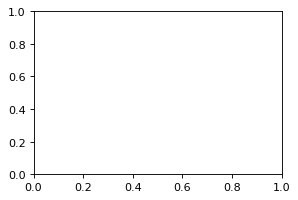

In [3]:
# plotagem
from pygame import Surface


plt.ioff()
fig, ax = plt.subplots(figsize=(4, 3), dpi=80)
fig.subplots_adjust(bottom=0.2)
canvas = FigureCanvasAgg(fig)

def desenhar_histograma(energias_cineticas, temperatura_atual) -> Surface:
    """Retorna uma superficie com o histograma desenhado"""
    ax.clear()
    if energias_cineticas:
        bins = np.linspace(0, energia_maxima_histograma, 20)
        contagens, bins, patches = ax.hist(energias_cineticas, bins=bins, color='blue', alpha=0.7)
        
        # distribuicao de Maxwell-Boltzmann
        if len(energias_cineticas) > 1:
            kT = temperatura_atual * kb
            x = np.linspace(0, energia_maxima_histograma, 100)
            # calcula largura do bin para normalização adequada
            largura_bin = bins[1] - bins[0]
            # distribuicao de Maxwell-Boltzmann normalizada corretamente
            maxwell = (len(energias_cineticas) * largura_bin * (x/(kT**2)) * np.exp(-x/kT))
            ax.plot(x, maxwell, 'r-', linewidth=2)
    
    ax.set_title('Distribuição de Energia Cinética')
    ax.set_xlabel('Energia (J)')
    ax.set_ylabel('Contagem')
    ax.set_xlim(0, energia_maxima_histograma)
    
    canvas.draw()
    renderer = canvas.get_renderer()
    raw_data = renderer.tostring_rgb()
    size = canvas.get_width_height()
    
    return pygame.image.fromstring(raw_data, size, "RGB")

In [4]:
sistema_particulas = SistemaParticulas(quantidade_inicial_particulas, temperatura_inicial)  
temperatura_atual = sistema_particulas.temperatura_medida

Loop de jogo

In [ ]:
pygame.init()

# inicializa o sistema de particulas
sistema_particulas = SistemaParticulas(quantidade_inicial_particulas, temperatura_inicial)

# configura a tela
screen = pygame.display.set_mode((LARGURA_TELA, ALTURA_TELA))
pygame.display.set_caption("Simulador de Partículas de Gás Ideal")
clock = pygame.time.Clock()
fonte = pygame.font.SysFont('Arial', 16)
fonte_titulo = pygame.font.SysFont('Arial', 24, bold=True)

# funcao pra desenhar botoes
def desenhar_botao(x, y, largura, altura, texto, ativo=True, cor=VERDE_ESCURO):
    """Desenha um botão verde que fica cinza se tiver inativo"""
    cor_botao = cor if ativo else CINZA_ESCURO

    pygame.draw.rect(screen, cor_botao, (x, y, largura, altura))
    pygame.draw.rect(screen, BRANCO, (x, y, largura, altura), 2)

    texto_surperficie = fonte.render(texto, True, BRANCO)
    texto_retangulo = texto_surperficie.get_rect(center=(x + largura/2, y + altura/2))
    screen.blit(texto_surperficie, texto_retangulo)
    return pygame.Rect(x, y, largura, altura)

def main():
    running = True
    pausado = False

    # retangulos dos botoes
    retangulo_botao_adicionar = pygame.Rect(0, 0, 0, 0)
    retangulo_botao_remover   = pygame.Rect(0, 0, 0, 0)
    retangulo_botao_aquecer   = pygame.Rect(0, 0, 0, 0)
    retangulo_botao_resfriar  = pygame.Rect(0, 0, 0, 0)

    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:
                    pausado = not pausado

                elif event.key == pygame.K_ESCAPE:
                    running = False

            elif event.type == pygame.MOUSEBUTTONDOWN and event.button == 1:
                posicao_mouse = pygame.mouse.get_pos()

                if retangulo_botao_adicionar.collidepoint(posicao_mouse):
                    sistema_particulas.adicionar_particulas(quantas_particulas_adicionar, sistema_particulas.temperatura_atual)

                elif retangulo_botao_remover.collidepoint(posicao_mouse):
                    sistema_particulas.remover_particulas(quantas_particulas_adicionar)

                elif retangulo_botao_aquecer.collidepoint(posicao_mouse) and sistema_particulas.temperatura_atual > 1300:
                    sistema_particulas.temperatura_alvo += 50 # K

                elif retangulo_botao_resfriar.collidepoint(posicao_mouse) and sistema_particulas.temperatura_atual > 50:
                    sistema_particulas.temperatura_alvo -= 50 # K
    
        if not pausado:
            sistema_particulas.atualizar_sistema(tempo_entre_frames)
            superficie_histograma = desenhar_histograma(sistema_particulas.energias_cineticas, sistema_particulas.temperatura_atual)
        
        # limpa a tela
        screen.fill(PRETO)
        
        # desenha titulos
        screen.blit(fonte_titulo.render("Simulação", True, BRANCO), (50, 50))
        screen.blit(fonte_titulo.render("Controles", True, BRANCO), (700, 50))
        screen.blit(fonte_titulo.render("Dados", True, BRANCO), (700, 300))

        # desenha caixa de simulacao e particulas
        pygame.draw.rect(screen, BRANCO, (POS_X_CAIXA_PX, POS_Y_CAIXA_PX, LARGURA_CAIXA_PX, ALTURA_CAIXA_PX), 2)
        # for p in sistema_particulas.particulas:
        #     pixel_central_x = int(POS_X_CAIXA_PX + p['posicao_x'] * PIXELS_POR_NM)
        #     pixel_central_y = int(POS_Y_CAIXA_PX + p['posicao_y'] * PIXELS_POR_NM)
        #     raio_em_pixels  = int(p['raio'] * PIXELS_POR_NM)
        #     pygame.draw.circle(screen, cor_particulas, )
        #     pygame.draw.circle(screen, cor_particulas, (pixel_central_x, pixel_central_y), raio_em_pixels)
    
    pygame.quit()
    sys.exit()

if __name__ == "__main__":
    main()

C:\Users\thiag\AppData\Local\Temp\ipykernel_5316\2654806905.py:128: RuntimeWarning: invalid value encountered in scalar divide
  normal_x, normal_y = distancia_x/distancia, distancia_y/distancia
C:\Users\thiag\AppData\Local\Temp\ipykernel_5316\1315167372.py:34: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  raw_data = renderer.tostring_rgb()


SystemExit: 

C:\Users\thiag\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
